In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets
!pip install pandas

In [3]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/jishnuparayilshibu/a-curated-list-of-image-deblurring-datasets")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aakashrocks
Your Kaggle Key: ··········


100%|██████████| 17.1G/17.1G [13:54<00:00, 22.0MB/s]


In [4]:
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
gauss_blur = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur')
gauss_blur.sort()
sharp = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp')
sharp.sort()

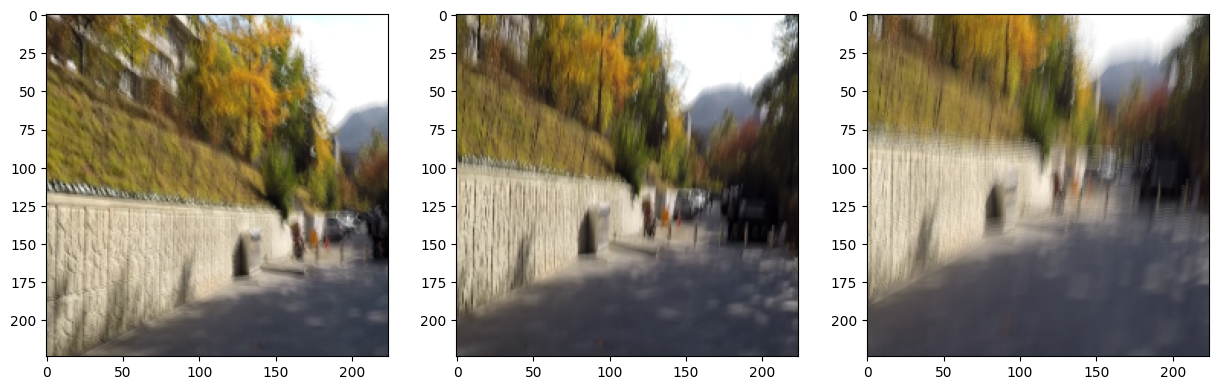

In [6]:
plt.figure(figsize=(15, 12))
for i in range(3):
    blur_image = plt.imread(f"/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur/{gauss_blur[i]}")
    blur_image = cv2.resize(blur_image, (224, 224))
    plt.subplot(1, 3, i+1)
    plt.imshow(blur_image)
plt.show()

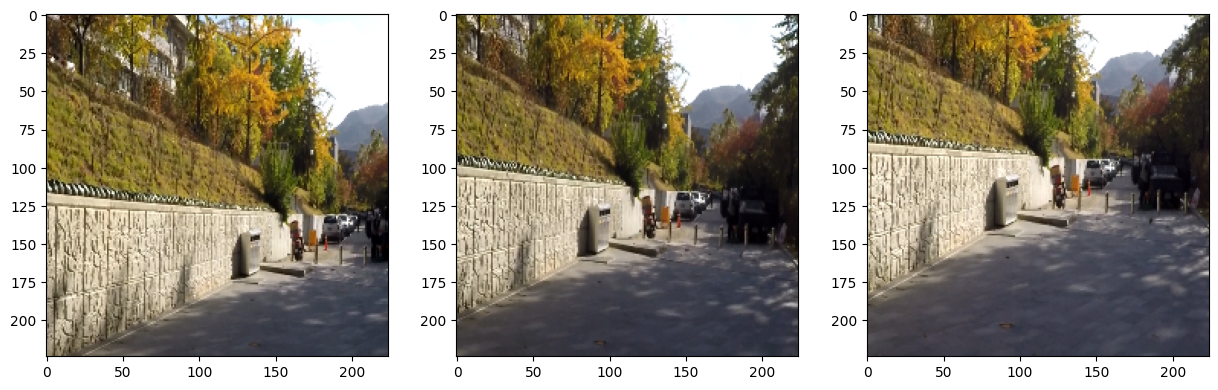

In [7]:
plt.figure(figsize=(15, 12))
for i in range(3):
    sharp_image = plt.imread(f"/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp/{sharp[i]}")
    sharp_image = cv2.resize(sharp_image, (224, 224))
    plt.subplot(1, 3, i+1)
    plt.imshow(sharp_image)
plt.show()

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import albumentations
import argparse

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from PIL import Image

In [9]:
import torch
import torch.nn as nn


class ResBlock(nn.Module):
    def __init__(self, indim=64, outdim=64):
        super(ResBlock, self).__init__()
        self.indim = indim
        self.outdim = outdim
        self.C1 = nn.Conv2d(indim, outdim, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.C2 = nn.Conv2d(outdim, outdim, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        out = self.C1(x)
        out = self.relu1(out)
        out = self.C2(out)
        out = out + x
        return out

class UpConvBlock(nn.Module):
    def __init__(self, ratio=4):
        super(UpConvBlock, self).__init__()
        self.conv = nn.Conv2d(3, 3*ratio**2, kernel_size=5, stride=1, padding=2)
        self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        out = self.conv(x)
        out = self.ps(out)
        return out

class PyramidBlockSingleScale(nn.Module):
    def __init__(self, block, num_layers, indim=3):
        super(PyramidBlockSingleScale, self).__init__()
        layers = []
        conv1 = nn.Conv2d(indim, 64, kernel_size=5, stride=1, padding=2)
        layers.append(conv1)

        for _ in range(num_layers):
            B = block(64, 64)
            layers.append(B)

        conv_final = nn.Conv2d(64, 3, kernel_size=5, stride=1, padding=2)
        layers.append(conv_final)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

class DeepDeblurSingleScale(nn.Module):
    def __init__(self, block, k=3):
        super(DeepDeblurSingleScale, self).__init__()
        layers_per_scale = 60 // k - 1

        self.pyramid = PyramidBlockSingleScale(block, layers_per_scale)

    def forward(self, B):
        L = self.pyramid(B)
        return L


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def DeepDeblur_single_scale():
    return DeepDeblurSingleScale(ResBlock)


if __name__ == '__main__':
    model = DeepDeblur_single_scale()
    print(model)
    string = ''
    string = string + '-' * 30 + '\n'
    string = string + 'Trainable params: ' + str(count_parameters(model)) + '\n'
    string = string + '-' * 30
    print(string)

DeepDeblurSingleScale(
  (pyramid): PyramidBlockSingleScale(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ResBlock(
        (C1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (relu1): ReLU(inplace=True)
        (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (2): ResBlock(
        (C1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (relu1): ReLU(inplace=True)
        (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (3): ResBlock(
        (C1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (relu1): ReLU(inplace=True)
        (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (4): ResBlock(
        (C1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (relu1): ReLU(inplace=True)
        (C2): Conv2d(64, 

In [10]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, negative_slope=0.2):
        super(Discriminator, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(128, 128, kernel_size=5, stride=4, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(256, 256, kernel_size=5, stride=4, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=4, padding=0, bias=False),
            nn.LeakyReLU(negative_slope, inplace=True)
        )

        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = torch.sigmoid(out)
        return out

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import albumentations
import argparse

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from PIL import Image

# Helper functions
image_dir = '/content/output_images'
os.makedirs(image_dir, exist_ok=True)

def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

batch_size = 2

gauss_blur = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur')
gauss_blur.sort()
sharp = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp')
sharp.sort()

# gauss_blur_test = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/blur')
# gauss_blur_test.sort()
# sharp_test = os.listdir('/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp')
# sharp_test.sort()

x_blur_train = []
for i in range(len(gauss_blur)):
    x_blur_train.append(gauss_blur[i])

y_sharp_train = []
for i in range(len(sharp)):
    y_sharp_train.append(sharp[i])

# x_blur_test = []
# for i in range(len(gauss_blur_test)):
#     x_blur_test.append(gauss_blur_test[i])

# y_sharp_test = []
# for i in range(len(sharp_test)):
#     y_sharp_test.append(sharp_test[i])

print(x_blur_train[10])
print(y_sharp_train[10])

(x_train, x_val, y_train, y_val) = train_test_split(x_blur_train, y_sharp_train, test_size=0.2)

# print(len(x_train))
# print(len(x_val))

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        blur_image = Image.open(f"/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur/{self.X[i]}")

        # Check if image is grayscale
        if blur_image.mode != 'RGB':
            return None

        if self.transforms:
            blur_image = self.transforms(blur_image)

        if self.y is not None:
            sharp_image = Image.open(f"/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp/{self.y[i]}")

            # Check if sharp image is grayscale
            if sharp_image.mode != 'RGB':
                return None

            sharp_image = self.transforms(sharp_image)
            return blur_image, sharp_image
        else:
            return blur_image

# Create train and validation datasets
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

# Remove grayscale images from the datasets
train_data = [data for data in train_data if data is not None]
val_data = [data for data in val_data if data is not None]

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


cuda:0
1006.png
1006.png


In [12]:
import os

import numpy as np
from PIL import Image
from torch.utils.tensorboard import SummaryWriter


def print_args(args):
    msg = ''
    msg += ('=' * 20 + '\n')
    msg += 'List of Arguments\n'
    msg += ('-' * 20 + '\n')
    for k, v in vars(args).items():
        msg += (str(k) + ' : ' + str(v) + '\n')
    msg += ('=' * 20)
    print(msg)


def get_summarywriter(experiment_id):
    log_path = os.path.join('./logs', experiment_id)

    if not os.path.exists(log_path):
        os.makedirs(log_path, exist_ok=True)
    print("saving tensorboard logs at '{}'".format(log_path))

    writer = SummaryWriter(log_path)
    assert writer is not None

    return writer


def save_image(img, path):
    img *= 255
    np.clip(img, 0, 255, out=img)
    Image.fromarray(img.astype('uint8'), 'RGB').save(path)


class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


if __name__ == '__main__':
    a = get_summarywriter('temp')
    print('done')
    b = AverageMeter('ma')

saving tensorboard logs at './logs/temp'
done


In [13]:
import copy
import glob
import numpy as np
import os
import random

import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image


def augment(input, label, crop_size, mu=0, sigma=2/255.):
    label_input = np.random.randint(0, 10) == 0
    change_saturation = np.random.randint(0, 10) == 0
    flip_h = np.random.randint(0, 2) == 0
    angle = random.choice([0, 90, 180, 270])

    shuffle_color = True
    add_noise = False
    label_input= False

    if label_input:
        input = copy.deepcopy(label)

    # Random crop
    if crop_size != -1:
        h, w = input.size
        rnd_h = random.randint(0, h - crop_size)
        rnd_w = random.randint(0, w - crop_size)
        input = TF.crop(input, rnd_w, rnd_h, crop_size, crop_size)
        label = TF.crop(label, rnd_w, rnd_h, crop_size, crop_size)

    if flip_h:
        input = TF.hflip(input)
        label = TF.hflip(label)

    if angle > 0:
        input = TF.rotate(input, angle)
        label = TF.rotate(label, angle)

    if change_saturation:
        saturation_factor = 1 + np.random.uniform(-0.5, 0.5)

        input = TF.adjust_saturation(input, saturation_factor)
        label = TF.adjust_saturation(label, saturation_factor)

    # Augmentation with numpy array
    input = np.array(input)
    label = np.array(label)

    if shuffle_color:
        channels_shuffled = np.random.permutation(3)

        input = input[:,:,channels_shuffled]
        label = label[:,:,channels_shuffled]

    if add_noise:
        noise = 255 * np.random.normal(mu, sigma, input.shape)

        input = input + noise
        label = label + noise

    np.clip(input, 0, 255, out=input)
    np.clip(label, 0, 255, out=label)

    input = Image.fromarray(input.astype('uint8'), 'RGB')
    label = Image.fromarray(label.astype('uint8'), 'RGB')

    return input, label


def get_normalize():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (1,1,1))
    ])
    return transform


class GoproDataset(data.Dataset):
    def __init__(self, root_dir, crop_size, phase):
        self.root_dir = root_dir
        # self.blur_type = blur_type
        self.crop_size = crop_size
        self.phase = phase

        self.normalize = get_normalize()

        assert self.phase in ['train', 'test']

        # if self.blur_type == 'lin':
        #     blur_dir = 'blur'
        # elif self.blur_type == 'gamma':
        #     blur_dir = 'blur_gamma'
        # else:
        #     raise ValueError('incorrect blur type given..')

        self.blur_list = glob.glob(os.path.join(root_dir, phase) + '/*/blur/*.*')
        self.sharp_list = glob.glob(os.path.join(root_dir, phase) + '/*/sharp/*.*')
        assert len(self.blur_list) == len(self.sharp_list)

        print('{} dataset contains total {:d} pair of images'.format(phase, len(self.blur_list)))

    def __getitem__(self, idx):
        blur1 = Image.open(self.blur_list[idx]).convert('RGB')
        sharp1 = Image.open(self.sharp_list[idx]).convert('RGB')

        if self.phase == 'train':
            blur1, sharp1 = augment(blur1, sharp1, self.crop_size)

        h, w = blur1.size

        blur2 = blur1.resize((h//2, w//2), Image.BICUBIC)
        sharp2 = sharp1.resize((h//2, w//2), Image.BICUBIC)

        blur3 = blur2.resize((h//4, w//4), Image.BICUBIC)
        sharp3 = sharp2.resize((h//4, w//4), Image.BICUBIC)

        blur1 = self.normalize(blur1)
        sharp1 = self.normalize(sharp1)

        blur2 = self.normalize(blur2)
        sharp2 = self.normalize(sharp2)

        blur3 = self.normalize(blur3)
        sharp3 = self.normalize(sharp3)

        return (blur1, blur2, blur3), (sharp1, sharp2, sharp3)

    def __len__(self):
        return len(self.blur_list)

In [14]:
import torch.utils.data as data

# from data import gopro_dataset


def create_dataloader(args, phase, inf=False):
    crop_size = args.crop_size if phase == 'train' else -1
    batch_size = args.batch_size if phase == 'train' else 1

    dataset = GoproDataset(
        root_dir=args.dataset,
        # blur_type=args.blur_type,
        crop_size=crop_size,
        phase=phase)

    dataloader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True if phase == 'train' else False,
        num_workers=args.n_cpu,
        drop_last=True if phase == 'train' else False)

    if inf:
        return inf_data_gen(dataloader)
    else:
        return dataloader


def inf_data_gen(loader):
    while True:
        for input, label in loader:
            yield (input, label)

In [1]:
import argparse
import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm

# from data import create_dataloader
# from models import deepdeblur, discriminator
# from utils.utils import get_summarywriter, print_args, AverageMeter


parser = argparse.ArgumentParser()

# settings
parser.add_argument('--seed', type=int, default=None,
                    help='seed for initializing training')
parser.add_argument('--gpu_id', type=str, default='0',
                    help='gpu id to use')
parser.add_argument('--n_cpu', type=int, default=8,
                    help='cpus for data processing')
parser.add_argument('--experiment_id', type=str, default=None,
                    help='checkpoint directory name (default: YY-MM-DD-HHMMSS)')

# training arguments
parser.add_argument('--n_epochs', type=int, default=20,
                    help='number of total epochs')
parser.add_argument('--n_iter_per_epoch', type=int, default=100,
                    help='number of iterations per single epoch')
parser.add_argument('--batch_size', type=int, default=2,
                    help='mini-batch size')
parser.add_argument('--lr', type=float, default=5e-5,
                    help='initial learning rate')
parser.add_argument('--lr_decay_step', type=int, default=150,
                    help='learning rate decay step')
parser.add_argument('--adv_lambda', type=float, default=1e-4,
                    help='adversarial loss weight constant')

# data arguments
# parser.add_argument('--dataset', type=str, default='GOPRO_Large',
#                     help='GOPRO | GOPRO_Large')
# # parser.add_argument('--blur_type', type=str, default='gamma',
# #                     help='gamma | lin')
# parser.add_argument('--crop_size', type=int, default=256,
#                     help='crop size')

# others
parser.add_argument('--log_interval', type=int, default=100,
                    help='log interval, iteration (default: 100)')
parser.add_argument('--val_interval', type=int, default=1,
                    help='validate interval, epoch (default: 10)')
parser.add_argument('--tensorboard', action='store_true',
                    help='visualize training?')
parser.add_argument('--save_path', type=str, default='checkpoints',
                    help='path to save checkpoints')

def main():

    args = parser.parse_args(args=[])

    # Manually set the arguments for Colab
    args.seed = 42
    args.gpu_id = '0'
    args.n_cpu = 4
    args.n_epochs = 1
    args.n_iter_per_epoch = 1
    args.batch_size = 2
    args.lr = 5e-5
    args.lr_decay_step = 150
    args.adv_lambda = 1e-4
    args.dataset = '/content/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro'
    # # args.blur_type = 'gamma'
    args.crop_size = 256
    args.log_interval = 100
    args.val_interval = 1
    args.tensorboard = False  # Set to True if you want to use TensorBoard
    args.save_path = '/content/drive/MyDrive/Gans_path'



    if args.seed is not None:
        print('seed number given => {:d}'.format(args.seed))
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)

    # args.dataset = os.path.join('./datasets', args.dataset)

    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # if args.experiment_id is not None:
    #     model_id = args.experiment_id
    # else:
    #     model_id = time.strftime('%Y-%m-%d-%H%M%S', time.localtime(time.time()))
    # args.save_path = os.path.join('checkpoints', model_id)
    # os.makedirs(args.save_path, exist_ok=True)
    # print('experiment id => {} \ncheckpoint path => {}'.format(model_id, args.save_path))

    writer = get_summarywriter(model_id) if args.tensorboard else None

    # inf_train_loader = create_dataloader(args, phase='train', inf=True)
    # val_loader = create_dataloader(args, phase='test')

    model = DeepDeblur_single_scale()
    model.to(device)
    netD = Discriminator()
    netD.to(device)

    train(trainloader, valloader, model, netD, device, writer, args)

    writer = get_summarywriter(model_id) if args.tensorboard else None


def validate(current_epoch, dataloader, model, device, writer, args):
    val_psnr = AverageMeter('PSNR')

    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)

            pred1 = model(blur_image)

            sharp1 = sharp_image.detach().clone().cpu().numpy().squeeze()
            pred1 = pred1.detach().clone().cpu().numpy().squeeze()

            np.clip(pred1, 0, 1.)

            sharp1 += 0.5
            pred1 += 0.5

            psnr = peak_signal_noise_ratio(sharp1, pred1, data_range=1.)

            val_psnr.update(psnr)

    print('>> PSNR on validate dataset: ', val_psnr.avg)
    if writer is not None:
        writer.add_scalar('Validate/'+val_psnr.name, val_psnr.avg, current_epoch)

def train(trainloader, valloader, model, netD, device, writer, args):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()

    g_optimizer = optim.Adam(model.parameters(), args.lr,
                             betas=(0.9,0.999),
                             eps=1e-8,
                             weight_decay=0)

    d_optimizer = optim.Adam(netD.parameters(), args.lr,
                             betas=(0.9,0.999),
                             eps=1e-8,
                             weight_decay=0)

    g_scheduler = optim.lr_scheduler.StepLR(
        g_optimizer,
        step_size=args.lr_decay_step,
        gamma=0.1)

    d_scheduler = optim.lr_scheduler.StepLR(
        d_optimizer,
        step_size=args.lr_decay_step,
        gamma=0.1)

    netD.train()

    real_label = torch.ones([args.batch_size, 1], device=device)
    fake_label = torch.zeros([args.batch_size, 1], device=device)

    d_losses = AverageMeter('D loss')
    total_losses = AverageMeter('Total G loss')
    content_losses = AverageMeter('Content loss')
    adv_losses = AverageMeter('Adversarial loss')

    print('start training..')
    for epoch in range(1, args.n_epochs + 1):
        model.train()

        for i in range(1, args.n_iter_per_epoch + 1):
            ########################
            # Update Discriminator #
            ########################
            for p in netD.parameters():
                p.requires_grad = True  # Set requires_grad=True for discriminator

            for inputs, labels in trainloader:
                blur1 = inputs.to(device)
                sharp1 = labels.to(device)

                pred1 = model(blur1)

                # compute adversarial loss
                real_loss = bce_loss(netD(sharp1), real_label)
                fake_loss = bce_loss(netD(pred1.detach()), fake_label)
                d_loss = real_loss + fake_loss

                # update discriminator
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

            ###########################
            # Update DeepDeblur model #
            ###########################
            for p in netD.parameters():
                p.requires_grad = False

            data_iterator = iter(trainloader)
            for i in range(args.n_iter_per_epoch):
                try:
                    inputs, labels = next(data_iterator)
                except StopIteration:
                    # If the iterator reaches the end, create a new iterator to start again
                    data_iterator = iter(trainloader)
                    inputs, labels = next(data_iterator)

                blur1 = inputs
                blur1 = blur1.to(device)
                sharp1 = labels
                sharp1 = sharp1.to(device)

                pred1 = model(blur1)

                # compute content loss
                mse_loss_1 = mse_loss(pred1, sharp1)

                # compute total losses for generator
                content_loss = (mse_loss_1)
                adv_loss = bce_loss(netD(pred1), real_label)

                total_g_loss = content_loss + args.adv_lambda * adv_loss

                # update generator
                g_optimizer.zero_grad()
                total_g_loss.backward()
                g_optimizer.step()

                ###########
                # Logging #
                ###########
                d_losses.update(d_loss.item())
                total_losses.update(total_g_loss.item())
                content_losses.update(content_loss.item())
                adv_losses.update(adv_loss.item())

                if i % args.log_interval == 0:
                    print('Epoch {:d}/{:d} | Iteration {:d}/{:d} | D loss {:.6f} | Total G loss {:.6f} | Content loss {:.6f} | Adversarial loss {:.6f}'.format(
                        epoch, args.n_epochs, i, args.n_iter_per_epoch, d_losses.avg, total_losses.avg, content_losses.avg, adv_losses.avg
                    ))
                    if writer is not None:
                        writer.add_scalar('Train/'+d_losses.name, d_losses.avg, d_losses.count)
                        writer.add_scalar('Train/'+total_losses.name, total_losses.avg, total_losses.count)
                        writer.add_scalar('Train/'+content_losses.name, content_losses.avg, content_losses.count)
                        writer.add_scalar('Train/'+adv_losses.name, adv_losses.avg, adv_losses.count)

        if epoch % args.val_interval == 0:
            validate(epoch, valloader, model, device, writer, args)
            torch.save(model.state_dict(), os.path.join(args.save_path, '{:d}.pth'.format(epoch)))

        g_scheduler.step()
        d_scheduler.step()


if __name__ == '__main__':
    main()

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
# import models
import torch

from torchvision.transforms import transforms
from torchvision.utils import save_image

def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, f"/content/{name}")

device = torch.device('cuda')

# # load the trained model
# model = model.to(device).eval()
# Create an instance of the enhanced autoencoder
model = DeepDeblur_single_scale()
model.load_state_dict(torch.load('/content/drive/MyDrive/Gans_path/2.pth'))
model = model.to(device)
model.eval()
# model = model.to(device)

# ...

# define transforms
import PIL.Image

def save_decoded_image(img, name):
    img = img.squeeze(0)  # Remove the batch dimension
    img = img.permute(1, 2, 0).cpu().numpy()  # Change tensor shape to (H, W, C) and move to CPU
    img = np.clip(img, 0, 1)  # Clip values between 0 and 1 (assuming values are in range [0, 1])
    img = (img * 255).astype(np.uint8)  # Convert to uint8 (0-255 range)
    image = PIL.Image.fromarray(img)
    image.save(f"/content/{name}")

# ... (previous code)

# Load the image using OpenCV
blur_image = cv2.imread('/content/drive/MyDrive/Dreambooth/motion_blur.jpg')
# Convert the image to RGB (assuming it's in BGR format by default in OpenCV)
blur_image = cv2.cvtColor(blur_image, cv2.COLOR_BGR2RGB)
# Resize the image to (224, 224) using PIL
blur_image = PIL.Image.fromarray(blur_image).resize((224, 224))
# Convert the PIL image to a PyTorch tensor and add a batch dimension
blur_image = transforms.ToTensor()(blur_image).unsqueeze(0).to(device)


with torch.no_grad():
    outputs = model(blur_image.to(device))  # Move the input tensor to the GPU
    save_decoded_image(outputs.cpu().data, name="output_dres_2.jpg")


In [2]:
#
# # %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread("/content/output_dres.jpg")
# imgplot = plt.imshow(img)
# plt.show()